In [1]:
import os
import sys
import pickle 

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
import seaborn as sns

import numpy as np
import numpy.ma as ma
import pandas as pd

import cooltools.lib.plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cooltools.lib import numutils
from matplotlib.colors import LinearSegmentedColormap

sys.path.append("/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments")
import simutils

In [2]:
def filter_diags(hmap, ignore_diags):
    hmap_diag_filtered = np.copy(hmap)
    for i in range(ignore_diags):
        np.fill_diagonal(hmap_diag_filtered[:, i:], np.nan)
        np.fill_diagonal(hmap_diag_filtered[i:, :], np.nan)
    return hmap_diag_filtered

def calc_ixns(subcomps_coarsened, ooe, n_diags=[0,0]):
    if n_diags:
        trans_ooe = filter_diags(ooe, n_diags[1])
        cis_ooe = filter_diags(ooe, n_diags[0])
    else:
        trans_ooe = cis_ooe = ooe

    mean_ixns = np.nan*np.ones((4,4))
    for i in range(3):
        for j in range(3):
            mean_ixns[i][j] = np.nanmean(trans_ooe[subcomps_coarsened==i].T[subcomps_coarsened==j])

    x_loc = subcomps_coarsened == 2

    XX_inter_mask = np.zeros((ooe.shape[0], ooe.shape[0]))
    XX_intra_mask = np.zeros((ooe.shape[0], ooe.shape[0]))
    for i in np.where(x_loc)[0]:
        for j in np.where(x_loc)[0]:
            XX_inter_mask[i,j] = (np.sum(x_loc[i:j]) < j-i)
            XX_intra_mask[i,j] = (np.sum(x_loc[i:j]) == j-i)
    XX_inter_mask = XX_inter_mask.astype(bool)
    XX_intra_mask = XX_intra_mask.astype(bool)

    mean_inter_X = np.nanmean(np.ma.array(trans_ooe, mask=~XX_inter_mask).compressed())    
    mean_intra_X = np.nanmean(np.ma.array(cis_ooe, mask=~XX_intra_mask).compressed())
    
    mean_ixns[2,2] = mean_inter_X
    mean_ixns[3,3] = mean_intra_X
    
    return mean_ixns

def make_ixn_df(sim_group_path, mtx_fh, AB_self_attr, XX=0):
    aa_list = []
    ab_list = []
    bb_list = []
    ax_list = []
    bx_list = []
    xx_intra_list = []
    xx_inter_list = []
    

    for AB in AB_self_attr:
        comp_dir = f'AA{AB:.2f}_BB{AB:.2f}_XX{XX:.2f}'
        sim_dir = 'Xboundaries'
        hmap_path = f'{sim_group_path}/{comp_dir}/{sim_dir}/results/heatmaps'
        if os.path.exists(f'{hmap_path}/{mtx_fh}'):
            with open(f'{hmap_path}/{mtx_fh}', 'rb') as o:
                mean_ixns = np.load(o)
            aa_list.append(mean_ixns[0,0])
            ab_list.append(mean_ixns[0,1])
            bb_list.append(mean_ixns[1,1])
            ax_list.append(mean_ixns[0,2])
            bx_list.append(mean_ixns[1,2])
            xx_inter_list.append(mean_ixns[2,2])
            xx_intra_list.append(mean_ixns[3,3])
        else:
            aa_list.append(np.nan)
            ab_list.append(np.nan)
            bb_list.append(np.nan)
            ax_list.append(np.nan)
            bx_list.append(np.nan)
            xx_inter_list.append(np.nan)
            xx_intra_list.append(np.nan)


    ixn_df = pd.DataFrame({
        "AA": aa_list,
        "AB": ab_list,
        "BB": bb_list,
        "AS": ax_list,
        "BS": bx_list,
        "SS_inter": xx_inter_list,
        "SS_intra": xx_intra_list,
    })

    ixn_df['AA_attr'] = AB_self_attr
    ixn_df['BB_attr'] = AB_self_attr
    ixn_df['SS_attr'] = XX
    
    return ixn_df

In [3]:
cutoff_rad = 5 
binSize = 5
base_path = f'/net/levsha/share/emily/notebooks/sims/bombyx/toy_models'

sim_dir = 'Xboundaries'

In [4]:
# load compartment labels
with open(f'{base_path}/polymer_info.pkl', 'rb') as f:
    monInfo = pickle.load(f)
    
chroms = monInfo['chroms']
L = monInfo['L']
n_per_chain = monInfo['L']//binSize
n_chains = 30
n_chains_per_sphere = 10

mon_id_tmp = monInfo['compartment_ID']
mon_id = np.array([mon_id_tmp[i] for i in range(0, L, binSize)])

AB_self_attr = [0.025, 0.05, 0.1, 0.15, 0.2]
XX = 0.00

lambda_ = 100
d_list = [50, 100, 200, 400, 1000]

In [5]:
# zoomify all of the matrices
for d in d_list:
    d_AB = d_X = d
    d_dir = f'lambda-{lambda_}_dX-{d_X}_dAB-{d_AB}'
    for AB in AB_self_attr:

        comp_dir = f'AA{AB:.2f}_BB{AB:.2f}_XX{XX:.2f}'
        sim = f'{comp_dir}__{sim_dir}'   
        hmap_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_chainMap.npy'
        sim_path = f'{base_path}/extrusion_and_compartments/extrusion_density_sims/{d_dir}/{comp_dir}/{sim_dir}'
        if os.path.exists(f'{sim_path}/results/heatmaps/{hmap_fh}'):
            continue
        else:
            hmap_fh_unbinned = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-1_IC_chainMap.npy'

            try:
                mat = np.load(f'{sim_path}/results/heatmaps/{hmap_fh_unbinned}')
            except FileNotFoundError:
                print(f'Hmap not found at {sim_path}/results/heatmaps/{hmap_fh_unbinned}')
                continue
            mat = mat/np.mean(np.diag(mat,k=1))
            mat_binned = numutils.zoom_array(mat, (L/binSize,L/binSize))

            save_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_chainMap.npy'
            with open(f'{sim_path}/results/heatmaps/{save_fh}', 'wb') as f:
                np.save(f, mat_binned)

In [6]:
for d in d_list:
    d_AB = d_X = d
    d_dir = f'lambda-{lambda_}_dX-{d_X}_dAB-{d_AB}'
    
    Ps_sim_path = f'{base_path}/extrusion_and_compartments/extrusion_density_sims/'+\
                    f'{d_dir}/AA{0:.2f}_BB{0:.2f}_XX{0:.2f}/{sim_dir}'
    Ps_fh = f'AA{0:.2f}_BB{0:.2f}_XX{0:.2f}__{sim_dir}__cutoff{cutoff_rad:04.1f}.txt'
    try:
        Ps = pd.read_csv(f'{Ps_sim_path}/results/Ps_scaling/{Ps_fh}', sep='\t')
        print(f'P(s) found at {Ps_sim_path}')
    except FileNotFoundError:
        print(f'No P(s) found at {Ps_sim_path}/results/Ps_scaling/{Ps_fh}')

    else:
        x, y = simutils.interpolate_Ps(Ps['dist'].values, Ps['Ps'].values, L)
        y = y/chroms
        y = y/y[1]
        exp_2bin = numutils.LazyToeplitz(y)
        exp = numutils.zoom_array(exp_2bin[:,:], (n_per_chain,n_per_chain))

        for AB in AB_self_attr:

            comp_dir = f'AA{AB:.2f}_BB{AB:.2f}_XX{XX:.2f}'
            sim = f'{comp_dir}__{sim_dir}'    

            hmap_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_chainMap.npy'
            ooe_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_OOE_chainMap.npy'

            sim_path = f'{base_path}/extrusion_and_compartments/extrusion_density_sims/{d_dir}/{comp_dir}/{sim_dir}'
            if os.path.exists(f'{sim_path}/results/heatmaps/{ooe_fh}'):
                print(f'OOE found for {d_dir}, {comp_dir}')
                continue
            else:
                if os.path.exists(f'{sim_path}/results/heatmaps/{hmap_fh}'):
                    print(f'computing OOE for {d_dir}, {comp_dir}')
                    mat = np.load(f'{sim_path}/results/heatmaps/{hmap_fh}')
                    mat = mat/np.mean(np.diag(mat,k=1))
                    ooe = mat/exp[:,:]
                    with open(f'{sim_path}/results/heatmaps/{ooe_fh}', 'wb') as f:
                        np.save(f, ooe)

P(s) found at /net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-50_dAB-50/AA0.00_BB0.00_XX0.00/Xboundaries


/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:61: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(bins)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:62: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(Ps)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:67: RuntimeWarning: divide by zero encountered in log10
  interp_x = np.log10(np.arange(last_bin))


OOE found for lambda-100_dX-50_dAB-50, AA0.03_BB0.03_XX0.00
OOE found for lambda-100_dX-50_dAB-50, AA0.05_BB0.05_XX0.00
OOE found for lambda-100_dX-50_dAB-50, AA0.10_BB0.10_XX0.00
OOE found for lambda-100_dX-50_dAB-50, AA0.15_BB0.15_XX0.00
OOE found for lambda-100_dX-50_dAB-50, AA0.20_BB0.20_XX0.00
P(s) found at /net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-100_dAB-100/AA0.00_BB0.00_XX0.00/Xboundaries


/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:61: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(bins)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:62: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(Ps)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:67: RuntimeWarning: divide by zero encountered in log10
  interp_x = np.log10(np.arange(last_bin))


OOE found for lambda-100_dX-100_dAB-100, AA0.03_BB0.03_XX0.00
OOE found for lambda-100_dX-100_dAB-100, AA0.05_BB0.05_XX0.00
OOE found for lambda-100_dX-100_dAB-100, AA0.10_BB0.10_XX0.00
OOE found for lambda-100_dX-100_dAB-100, AA0.15_BB0.15_XX0.00
OOE found for lambda-100_dX-100_dAB-100, AA0.20_BB0.20_XX0.00
P(s) found at /net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-200_dAB-200/AA0.00_BB0.00_XX0.00/Xboundaries


/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:61: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(bins)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:62: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(Ps)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:67: RuntimeWarning: divide by zero encountered in log10
  interp_x = np.log10(np.arange(last_bin))


OOE found for lambda-100_dX-200_dAB-200, AA0.03_BB0.03_XX0.00
OOE found for lambda-100_dX-200_dAB-200, AA0.05_BB0.05_XX0.00
OOE found for lambda-100_dX-200_dAB-200, AA0.10_BB0.10_XX0.00
OOE found for lambda-100_dX-200_dAB-200, AA0.15_BB0.15_XX0.00
OOE found for lambda-100_dX-200_dAB-200, AA0.20_BB0.20_XX0.00
P(s) found at /net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-400_dAB-400/AA0.00_BB0.00_XX0.00/Xboundaries


/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:61: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(bins)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:62: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(Ps)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:67: RuntimeWarning: divide by zero encountered in log10
  interp_x = np.log10(np.arange(last_bin))


OOE found for lambda-100_dX-400_dAB-400, AA0.03_BB0.03_XX0.00
OOE found for lambda-100_dX-400_dAB-400, AA0.05_BB0.05_XX0.00
OOE found for lambda-100_dX-400_dAB-400, AA0.10_BB0.10_XX0.00
OOE found for lambda-100_dX-400_dAB-400, AA0.15_BB0.15_XX0.00
OOE found for lambda-100_dX-400_dAB-400, AA0.20_BB0.20_XX0.00
P(s) found at /net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/extrusion_density_sims/lambda-100_dX-1000_dAB-1000/AA0.00_BB0.00_XX0.00/Xboundaries


/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:61: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(bins)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:62: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(Ps)
/net/levsha/share/emily/notebooks/sims/bombyx/toy_models/extrusion_and_compartments/simutils.py:67: RuntimeWarning: divide by zero encountered in log10
  interp_x = np.log10(np.arange(last_bin))


OOE found for lambda-100_dX-1000_dAB-1000, AA0.03_BB0.03_XX0.00
OOE found for lambda-100_dX-1000_dAB-1000, AA0.05_BB0.05_XX0.00
OOE found for lambda-100_dX-1000_dAB-1000, AA0.10_BB0.10_XX0.00
OOE found for lambda-100_dX-1000_dAB-1000, AA0.15_BB0.15_XX0.00
OOE found for lambda-100_dX-1000_dAB-1000, AA0.20_BB0.20_XX0.00


In [7]:
mask = np.arange(n_per_chain)
mask = mask[None, :] - mask[:, None]

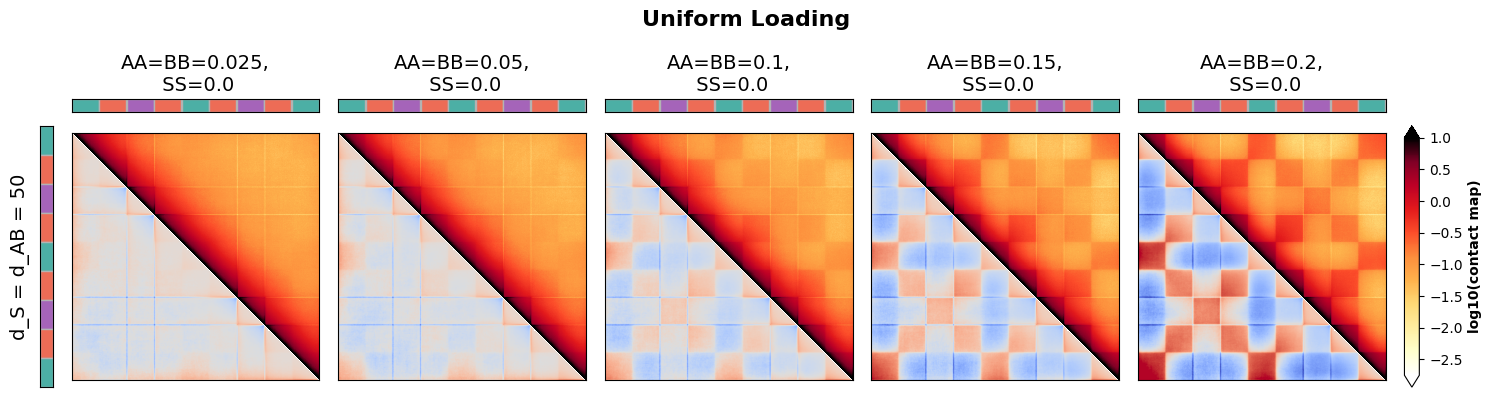

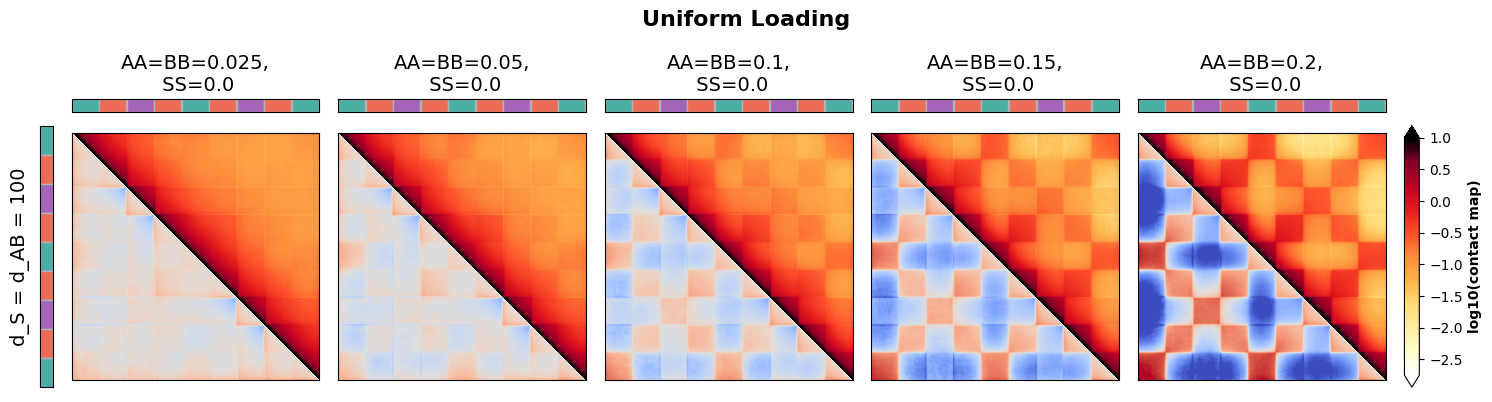

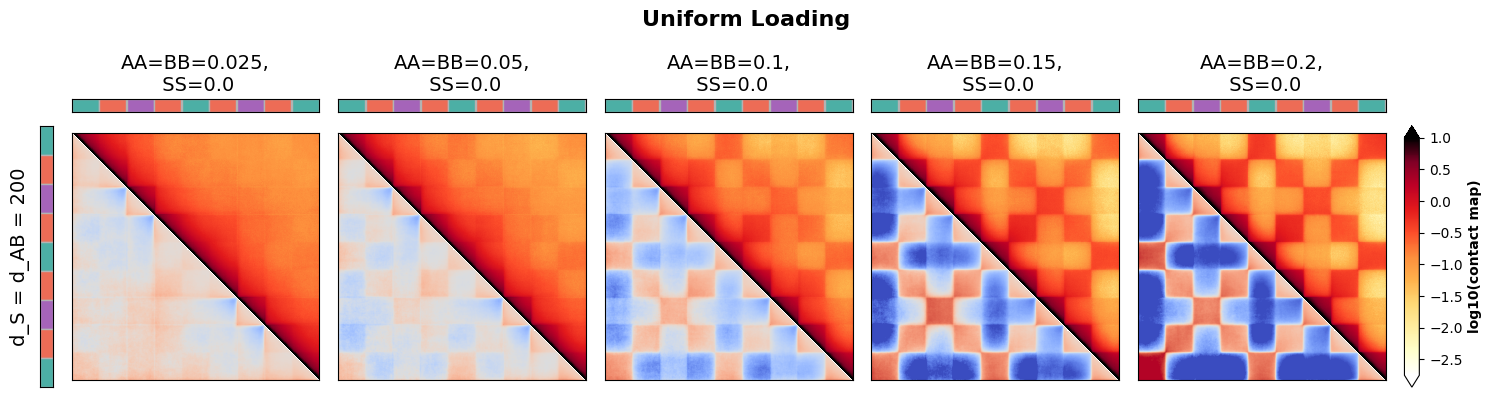

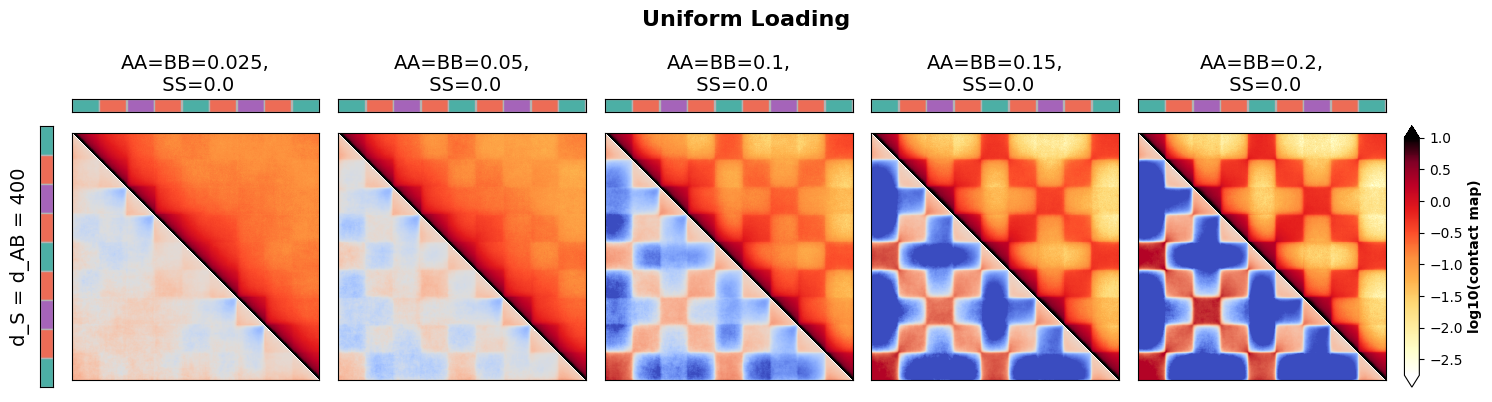

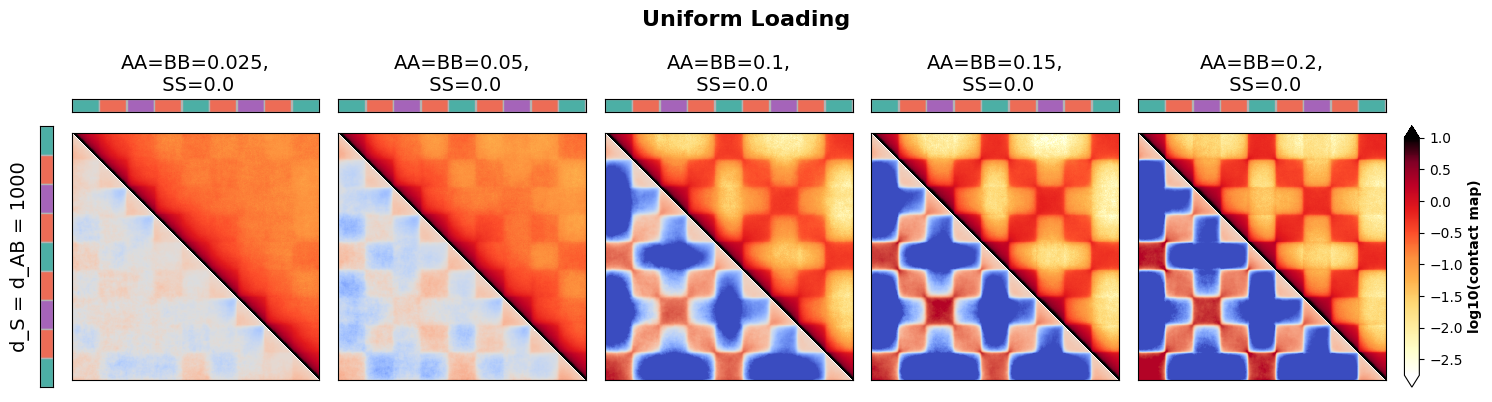

In [8]:
landscape = ['B','A','X','A','B','A','X','A','B']
colors = {'A':'#ed6c56','B':'#4cafa5','X':'#a564b9'}

n_row = 1
n_col = len(AB_self_attr)

for d in d_list:
    d_AB = d_X = d
    d_dir = f'lambda-{lambda_}_dX-{d_X}_dAB-{d_AB}'
    fig = plt.figure(figsize=(n_col*3, n_row*4))
    gs = GridSpec(nrows=1+n_row, ncols=1+n_col+1,
                  height_ratios=[5]+[100]*n_row,
                  width_ratios=[5]+[100]*n_col+[6])

    r = 0
    for c, AB in enumerate(AB_self_attr):
        comp_dir = f'AA{AB:.2f}_BB{AB:.2f}_XX{XX:.2f}'
        sim = f'{comp_dir}__{sim_dir}'    

        hmap_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_chainMap.npy'
        ooe_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_OOE_chainMap.npy'

        sim_path = f'{base_path}/extrusion_and_compartments/extrusion_density_sims/{d_dir}/{comp_dir}/{sim_dir}'
        sim = f'{comp_dir}__{sim_dir}'    
        hmap_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_chainMap.npy'

        try:
            mat = np.load(f'{sim_path}/results/heatmaps/{hmap_fh}')
        except FileNotFoundError:
            #print(f'{sim_path}/results/heatmaps/{hmap_fh}')
            mat = np.zeros((n_per_chain, n_per_chain))

        try:
            ooe = np.load(f'{sim_path}/results/heatmaps/{ooe_fh}')
        except FileNotFoundError:
            print(f'{sim_path}/results/heatmaps/{hmap_fh}')
            ooe = np.zeros((n_per_chain, n_per_chain))
        ax = fig.add_subplot(gs[r+1, c+1])

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim([0, mat.shape[0]])
        ax.set_ylim([mat.shape[0], 0])

        hmap_img = ax.imshow(ma.masked_array(np.log10(mat/np.nanmean(mat)), mask=mask<0), cmap='fall', interpolation='none',
                    vmin=-2.75, vmax=1,
                   )
        ooe_img = ax.imshow(ma.masked_array(np.log2(ooe), mask=mask>=0), cmap='coolwarm', 
                        vmin=-2, vmax=2,
                   )
        if not r:
            tax = fig.add_subplot(gs[0, c + 1], sharex=ax)
            tax.set_title(f'AA=BB={AB},\n SS={XX}', fontsize=14)

            for i in range(len(landscape)):
                tax.set_xticks([])
                tax.set_yticks([])
                tax.add_patch(Rectangle(xy=(i*400/binSize, 0), width=(-5+400-3)/binSize,
                          height=1, facecolor=colors[landscape[i]], edgecolor='0.7'))
        if not c:
            lax = fig.add_subplot(gs[r+1,0], sharey=ax)
            lax.set_ylabel(f'd_S = d_AB = {d_X}', fontsize=14)

            for i in range(len(landscape)):
                lax.set_xticks([])
                lax.set_yticks([])
                lax.add_patch(Rectangle(xy=(0,i*400/binSize), width=1,
                          height=400/binSize, facecolor=colors[landscape[i]], edgecolor='0.7'))

    hmap_cax = fig.add_subplot(gs[1:n_row+1,-1])
    plt.colorbar(hmap_img, hmap_cax, extend='both')
    hmap_cax.yaxis.set_label_position("right")
    hmap_cax.set_ylabel('log10(contact map)', fontweight='bold')
    fig.suptitle(f'Uniform Loading', fontsize=16, fontweight='bold', y=.99)

    fig.tight_layout(pad=1)


In [9]:
comp_sizes = np.diff(np.concatenate([np.array([0]), np.where(np.diff(mon_id) != 0)[0]]))
biggest_comp = max(comp_sizes)

mtx_fh = f'mean_ixns.npy'
for d in d_list:
    d_AB = d_X = d
    d_dir = f'lambda-{lambda_}_dX-{d_X}_dAB-{d_AB}'

    for AB in AB_self_attr:

        comp_dir = f'AA{AB:.2f}_BB{AB:.2f}_XX{XX:.2f}'
        sim = f'{comp_dir}__{sim_dir}'    

        ooe_fh = f'{sim}__cutoff-{cutoff_rad:04.1f}_binSize-{binSize}_IC_OOE_chainMap.npy'

        sim_path = f'{base_path}/extrusion_and_compartments/extrusion_density_sims/{d_dir}/{comp_dir}/{sim_dir}'
        try:
            ooe = np.load(f'{sim_path}/results/heatmaps/{ooe_fh}')
        except FileNotFoundError:
            continue
        if os.path.exists(f'{sim_path}/results/heatmaps/{mtx_fh}'):
            print(f'mean interactions for {sim} already exist')
            continue
        else:
            print(f'computing ixns for {sim_path}')
            mean_ixns = calc_ixns(subcomps_coarsened=mon_id, ooe=ooe, n_diags=[0,biggest_comp])
            with open(f'{sim_path}/results/heatmaps/{mtx_fh}', 'wb') as o:
                np.save(o, mean_ixns)   

mean interactions for AA0.03_BB0.03_XX0.00__Xboundaries already exist
mean interactions for AA0.05_BB0.05_XX0.00__Xboundaries already exist
mean interactions for AA0.10_BB0.10_XX0.00__Xboundaries already exist
mean interactions for AA0.15_BB0.15_XX0.00__Xboundaries already exist
mean interactions for AA0.20_BB0.20_XX0.00__Xboundaries already exist
mean interactions for AA0.03_BB0.03_XX0.00__Xboundaries already exist
mean interactions for AA0.05_BB0.05_XX0.00__Xboundaries already exist
mean interactions for AA0.10_BB0.10_XX0.00__Xboundaries already exist
mean interactions for AA0.15_BB0.15_XX0.00__Xboundaries already exist
mean interactions for AA0.20_BB0.20_XX0.00__Xboundaries already exist
mean interactions for AA0.03_BB0.03_XX0.00__Xboundaries already exist
mean interactions for AA0.05_BB0.05_XX0.00__Xboundaries already exist
mean interactions for AA0.10_BB0.10_XX0.00__Xboundaries already exist
mean interactions for AA0.15_BB0.15_XX0.00__Xboundaries already exist
mean interactions fo

In [10]:
concat_list = []
for d in d_list:
    d_AB = d_X = d
    d_dir = f'lambda-{lambda_}_dX-{d_X}_dAB-{d_AB}'
    sim_group_path = f'{base_path}/extrusion_and_compartments/extrusion_density_sims/{d_dir}'
    tmp_df = make_ixn_df(sim_group_path, mtx_fh, AB_self_attr, XX)
    tmp_df['d_S'] = d_X
    tmp_df['d_AB'] = d_AB
    concat_list.append(tmp_df)
full_df = pd.concat(concat_list, axis=0).reset_index(drop=True)

In [11]:
full_df["comp_score"] = np.round(\
                            (full_df["AA"]+full_df["BB"]+full_df["SS_inter"]-(full_df["AB"]+full_df["AS"]+full_df["BS"]))/\
                            (full_df["AA"]+full_df["BB"]+full_df["SS_inter"]+ full_df["AB"]+full_df["AS"]+full_df["BS"]),\
                                 1)

In [12]:
full_df['d_AB'] = np.where(full_df['d_AB'] == 0, np.inf, full_df['d_AB'])
full_df['d_ratio'] = np.round(full_df['d_AB']/full_df['d_S'])
full_df['S smoothness'] = np.std(full_df[["AS", "BS", "SS_inter"]], axis=1)
full_df["comp_score"] = (full_df["AA"]+full_df["BB"]+full_df["SS_inter"]-(full_df["AB"]+full_df["AS"]+full_df["BS"]))/\
                            (full_df["AA"]+full_df["BB"]+full_df["SS_inter"]+ full_df["AB"]+full_df["AS"]+full_df["BS"])

In [13]:
if full_df['SS_inter'].isnull().any():
    missing_sims = full_df.isnull().any(axis=1)
    full_df.iloc[missing_sims[missing_sims == True].index]
else:
    full_df.to_csv("ixn_df.csv", sep="\t")